In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import plotly.express as px
import pickle
import matplotlib.pyplot as plt

# read dataset
df = pd.read_csv("ALLFLOWMETER_HIKARI2021.csv")
df  # debugging table plotting

,Unnamed: 0.1,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,0,0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,1
1,1,1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,1
2,2,2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,1
3,3,3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,1
4,4,4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555273,555273,280838,C9b6Aa2csiogu3vVp9,103.255.15.42,138,103.255.15.255,138,0.000000,1,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,XMRIGCC CryptoMiner,1
555274,555274,280839,CGDT4r4PAbp3mvaI6k,103.255.15.42,138,103.255.15.255,138,0.000000,1,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,XMRIGCC CryptoMiner,1
555275,555275,280840,CJUxTk4Qd0kHliUKR9,103.255.15.42,138,103.255.15.255,138,0.000000,1,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,XMRIGCC CryptoMiner,1
555276,555276,280841,CknUJi2R1iYJG3li3k,103.255.15.42,138,103.255.15.255,138,0.000000,1,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,XMRIGCC CryptoMiner,1


# 0. Step - Get the behavior distribution

<AxesSubplot:ylabel='traffic_category'>

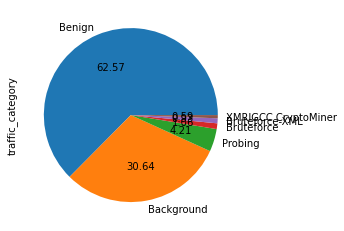

In [4]:
y = df['traffic_category']
y.value_counts().plot.pie(autopct='%.2f')

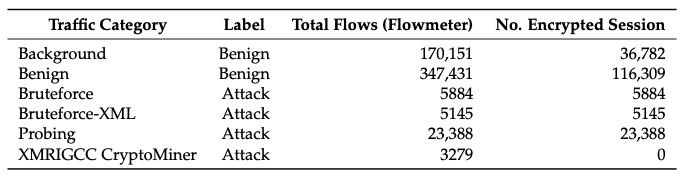

# 1. Step - Undersampling/Downsampling

### Reduce the amount of samples for the non-malicious entries of the dataset
##### *Benign & Background* 

In [5]:
bening_entries = df[df['traffic_category'] == "Benign"]
background_entries = df[df['traffic_category'] == "Background"]
print(bening_entries.shape)
print(background_entries.shape)

(347431, 88)
(170151, 88)


In [6]:
from sklearn.utils import resample
benign_downsampling = resample(bening_entries, n_samples=20000, random_state=42)
background_downsampling = resample(background_entries, n_samples=20000, random_state=42)
print(benign_downsampling.shape)
print(background_downsampling.shape)
dropped_df = df.drop(df.index[df['traffic_category'] == "Benign"], inplace = True)
dropped_df = df.drop(df.index[df['traffic_category'] == "Background"], inplace = True)
df
print(df.Label.unique())
df = pd.concat([df, benign_downsampling, background_downsampling])
df.columns

(20000, 88)
(20000, 88)
[1]


,Unnamed: 0.1,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,0,0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,0,Bruteforce-XML,1
1,1,1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.000000e+00,29200,65160,0,Bruteforce-XML,1
2,2,2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.000000e+00,29200,65160,0,Bruteforce-XML,1
3,3,3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.000000e+00,29200,65160,0,Bruteforce-XML,1
4,4,4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.000000e+00,29200,65160,0,Bruteforce-XML,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37605,37605,26576,Cf2xw8176ghqQ7bOu5,103.255.15.27,51872,103.255.15.23,42000,0.000114,1,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,0,29200,Background,0
119093,119093,108064,CqZlYc3rTFW48tHJ2i,103.255.15.23,41534,8.8.8.8,53,5.050906,4,3,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,Background,0
92267,92267,81238,C59Lxe3M4YECmijE1h,103.255.15.23,58548,151.101.25.188,443,1.453390,31,28,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65535,0,Background,0
163421,163421,152392,COxrqm1anTfbK8ESef,99.63.219.149,63564,103.255.15.23,80,31.249826,1,6,...,7.999965e+06,1.620103e+07,2.420100e+07,1.210050e+07,5.799030e+06,5840,29200,5840,Background,0


<AxesSubplot:ylabel='traffic_category'>

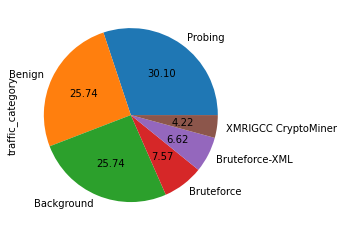

In [7]:
y = df['traffic_category']
y.value_counts().plot.pie(autopct='%.2f')

In [8]:
traffic_category_replacement_matrix = {
    'Bruteforce-XML': 0,
    'Bruteforce': 1,
    'XMRIGCC CryptoMiner': 2,
    'Probing': 3,
    'Background': 4,
    'Benign': 5
}
df.traffic_category = df.traffic_category.replace(traffic_category_replacement_matrix)
labels = df.traffic_category
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [9]:
# Extract labels and test, train split 
label = df[['traffic_category', 'Label']].copy()
df_values_no_traffic = df.drop(columns=['uid', 'originh', 'originp', 'responh', 'responp','traffic_category', 'Label'])

x_train, x_test, y_train, y_test = train_test_split(df_values_no_traffic, label['Label'], test_size=0.2)

In [10]:
# SVC

clf = SVC(gamma='auto')

clf.fit(x_train, y_train)

with open('url_analysis_svc.model', 'wb') as handle:
    pickle.dump(clf, handle)


In [12]:
# Testing SVC
from sklearn.metrics import classification_report

with open('url_analysis_svc.model', 'rb') as handle:
    clf = pickle.load(handle)


pred_labels = clf.predict(x_test)

print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.38      0.53      7976
           1       0.59      0.96      0.73      7564

    accuracy                           0.66     15540
   macro avg       0.75      0.67      0.63     15540
weighted avg       0.75      0.66      0.63     15540

